#LSTM Tagging Article English Model

##Import librairies

In [86]:
import os
from os.path import isfile, join
from os import walk
from __future__ import print_function

from keras.preprocessing import sequence
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import Dropout
from keras.layers import LSTM
from keras.datasets import imdb
import numpy as np

from sklearn.model_selection import train_test_split
import pickle
import pandas as pd

import zipfile
import keras
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import pickle



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


##Import Files

Import datas, store them in a dataframe, use them to train the english model.

In [0]:
#Zip file to import and decompress

with zipfile.ZipFile("edited-bbc-fulltext.zip", 'r') as zip_ref:
    zip_ref.extractall()

In [89]:
#Create dataframe to store texts and their respective label
df = pd.DataFrame(columns=['Text','Label'])

#Get labels from directories names  
label_list = []
for (dirpath, dirnames, filenames) in walk(os.path.join("edited-bbc-fulltext/bbc")):
    label_list.extend(dirnames)

print(label_list)

#Store texts and labels in the dataframe
i=0       
for label in label_list:
    for (dirpath, dirnames, filenames) in walk(os.path.join("edited-bbc-fulltext/bbc",label)):
        for file in filenames:
            with open('edited-bbc-fulltext/bbc/'+label+"/"+file, 'r') as content_file:
              content = content_file.read()
            df.loc[i] = [content, label]
            i = i + 1
            

['business', 'tech', 'sport', 'entertainment', 'politics']


In [0]:
print(df)

                                                   Text     Label
0     Clarke plans migrant point scheme\n\nAnyone pl...  politics
1     Cardinal criticises Iraq war cost\n\nBillions ...  politics
2     Labour's core support takes stock\n\nTony Blai...  politics
3     Howard rejects BNP's claim\n\nTory leader Mich...  politics
4     Blair dismisses quit claim report\n\nTony Blai...  politics
...                                                 ...       ...
2219  Ask Jeeves joins web log market\n\nAsk Jeeves ...      tech
2220  Screensaver tackles spam websites\n\nNet users...      tech
2221  Napster offers rented music to go\n\nMusic dow...      tech
2222  Mobile gaming takes off in India\n\nGaming on ...      tech
2223  'Friends fear' with lost mobiles\n\nPeople are...      tech

[2224 rows x 2 columns]


##Split data in test set and train set

In [90]:
#We split the main dataframe in four series :
# - X_train : serie wich contains texts for the train set 
# - X_test : serie wich contains texts for the test set 
# - y_train : serie which contains labels of the texts from X_train
# - y_test : serie which contains labels of the texts from X_test

X_train, X_test, y_train, y_test = train_test_split(df["Text"], df["Label"], test_size=0.33, random_state=42)

print("Train set :")
print("Shape of the train set : ")
print(X_train.shape)
print(X_train)
print("\n")
print(y_train)
print(y_train.shape)

print("\n")
print("\n")

print("Test set :")
print("Shape of the test set : ")
print(X_test.shape)
print(X_test)
print("\n")
print(y_test)
print(y_test.shape)

Train set :
Shape of the train set : 
(1490,)
619     Firefox browser takes on Microsoft\n\nMicrosof...
1999    'Best person' for top legal job\n\nThe "best p...
158     Card fraudsters 'targeting web'\n\nNew safegua...
1569    Franz man seeks government help\n\nFranz Ferdi...
272     Share boost for feud-hit Reliance\n\nThe board...
                              ...                        
1638    Volcano drama erupts on BBC One\n\nSupervolcan...
1095    Reds sink 10-man Magpies\n\nTitus Bramble's ow...
1130    Bomb threat at Bernabeu stadium\n\nSpectators ...
1294    Newcastle line up Babayaro\n\nNewcastle manage...
860     Camera phones are 'must-haves'\n\nFour times m...
Name: Text, Length: 1490, dtype: object


619              tech
1999         politics
158          business
1569    entertainment
272          business
            ...      
1638    entertainment
1095            sport
1130            sport
1294            sport
860              tech
Name: Label, Length: 1490, dtype

##Preprocessing datas

Before creating a model, we need to preprocess the datas.



In [91]:
#Cleaning datas 
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

X_train_cleaned = list()
X_test_cleaned = list()

for x in X_train :
    text = str(x)
    text = text.lower()
    text = REPLACE_BY_SPACE_RE.sub(' ',text)
    text = BAD_SYMBOLS_RE.sub(' ',text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) 
    X_train_cleaned.append(text)

for x in X_test :
    text = str(x)
    text = text.lower()
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
    text = BAD_SYMBOLS_RE.sub(' ', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) 
    X_test_cleaned.append(text)

print(X_test_cleaned)   




['french suitor holds lse meeting european stock market euronext met london stock exchange lse amid speculation may ready launch cash bid euronext chief jean francois theodore held talks lse boss clara furse day rival deutsche boerse put forward bid case german exchange said held constructive professional friendly talks lse euronext declined comment talks ended friday speculation mounting germans may raise bid 1 5bn deutsche boerse previously offered 1 3bn rejected lse euronext rumoured facilities place fund 1 4bn cash bid far however neither tabled formal bid deal either bidder would create biggest stock market operator europe second biggest world new york stock exchange speculation euronext would use friday meeting opportunity take advantage growing disquiet deutsche boerse plans dominance london market unions deutsche boerse staff frankfurt reportedly expressed fears 300 jobs would moved london takeover successful works council expressed concerns equities derivatives trade could man

In [0]:
#Data preprocessing can be done 
#Change num_words
tokenizer = keras.preprocessing.text.Tokenizer(num_words=500, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ')
X_train_temp = list()
X_test_temp = list()

for x in X_train_cleaned :
    x_preprocessed = text_to_word_sequence(x)
    X_train_temp.append(x_preprocessed)
    #print(x_preprocessed)

for x in X_test_cleaned :
    x_preprocessed = text_to_word_sequence(x)
    X_test_temp.append(x_preprocessed)
    #print(x_preprocessed)

docs = X_train_temp + X_test_temp

tokenizer.fit_on_texts(docs)

X_train_preprocessed = tokenizer.texts_to_sequences(X_train_temp)
X_test_preprocessed = tokenizer.texts_to_sequences(X_test_temp)

In [93]:
#Summarize
print(tokenizer.word_counts)
print(tokenizer.document_count)
print(tokenizer.word_index)
print(tokenizer.word_docs)

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

OrderedDict([('firefox', 30), ('browser', 47), ('takes', 125), ('microsoft', 277), ('internet', 309), ('explorer', 21), ('serious', 112), ('rival', 107), ('long', 444), ('awaited', 11), ('1', 901), ('0', 276), ('web', 197), ('released', 228), ('people', 2045), ('get', 891), ('excited', 17), ('new', 1978), ('software', 382), ('especially', 95), ('program', 102), ('game', 871), ('music', 839), ('movie', 167), ('player', 308), ('release', 165), ('first', 1353), ('full', 257), ('version', 185), ('managed', 63), ('drum', 5), ('respectable', 8), ('amount', 124), ('pre', 151), ('launch', 158), ('fervour', 3), ('fans', 206), ('banded', 1), ('together', 159), ('raise', 117), ('cash', 195), ('pay', 291), ('advert', 13), ('york', 175), ('times', 305), ('announcing', 20), ('available', 210), ('9', 235), ('november', 213), ('might', 237), ('even', 496), ('cause', 65), ('heads', 29), ('turn', 146), ('steadily', 10), ('winning', 246), ('away', 314), ('giant', 158), ('created', 123), ('mozilla', 11), 

In [94]:
#Find max size
maxTrain = 0
for listWord in X_train_preprocessed :
  size = len(listWord)
  if size > maxTrain :
    maxTrain = size
maxTrain

maxTest = 0
for listWord in X_test_preprocessed :
  size = len(listWord)
  if size > maxTest :
    maxTest = size  
maxTest

maxShape = 0
if maxTest > maxTrain :
  maxShape = maxTest
else :
  maxShape = maxTrain

maxShape


779

In [95]:
X_train = sequence.pad_sequences(X_train_preprocessed, maxlen=maxShape, value=0)
X_test = sequence.pad_sequences(X_test_preprocessed, maxlen=maxShape, value=0)


print('x_train shape:', X_train.shape)
print('x_test shape:', X_test.shape)

print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)
print(X_train)

x_train shape: (1490, 779)
x_test shape: (734, 779)
y_train shape: (1490,)
y_test shape: (734,)
[[  0   0   0 ... 461 197  98]
 [  0   0   0 ... 292 268 180]
 [  0   0   0 ... 222 204  65]
 ...
 [  0   0   0 ... 465 162   6]
 [  0   0   0 ...  80 430 426]
 [  0   0   0 ...  31 109   1]]


In [96]:
#Labels = 'politics', 'sport', 'business', 'entertainment' and 'tech'
v_temp = []

y_train_temp = pd.get_dummies(y_train, prefix="Label")
y_test_temp = pd.get_dummies(y_test, prefix="Label")
  
y_train = y_train_temp
y_test = y_test_temp

print(y_train)

      Label_business  Label_entertainment  ...  Label_sport  Label_tech
619                0                    0  ...            0           1
1999               0                    0  ...            0           0
158                1                    0  ...            0           0
1569               0                    1  ...            0           0
272                1                    0  ...            0           0
...              ...                  ...  ...          ...         ...
1638               0                    1  ...            0           0
1095               0                    0  ...            1           0
1130               0                    0  ...            1           0
1294               0                    0  ...            1           0
860                0                    0  ...            0           1

[1490 rows x 5 columns]


##Model

In [99]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import SpatialDropout1D
from keras.layers import GlobalMaxPooling1D


# Parameters
max_features = 5000
# cut texts after this number of words (among top max_features most common words)
batch_size = 200
NUM_EPOCHS = 20

earlystop= EarlyStopping(patience=5, monitor="val_loss")
learning_rate_reduction = ReduceLROnPlateau(monitor="val_acc", patience=2, verbose=1, factor=0.5, min_lr=0.00001)
callbacks = [earlystop, learning_rate_reduction]


print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 64, input_length=maxShape))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(64, activation="relu"))
model.add(Dense(5, activation='softmax'))

# try using different optimizers and different optimizer configs
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
H = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=NUM_EPOCHS,
          validation_data=(X_test, y_test),
          callbacks=callbacks)
score, acc = model.evaluate(X_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)



Build model...
Train...
Train on 1490 samples, validate on 734 samples
Epoch 1/20
1490/1490 [==============================] - 15s 10ms/step - loss: 1.6068 - acc: 0.2550 - val_loss: 1.6021 - val_acc: 0.2371
Epoch 2/20
1490/1490 [==============================] - 12s 8ms/step - loss: 1.5912 - acc: 0.3221 - val_loss: 1.5804 - val_acc: 0.3174
Epoch 3/20
1490/1490 [==============================] - 11s 7ms/step - loss: 1.5410 - acc: 0.4034 - val_loss: 1.4638 - val_acc: 0.4469
Epoch 4/20
1490/1490 [==============================] - 11s 7ms/step - loss: 1.3903 - acc: 0.4879 - val_loss: 1.2550 - val_acc: 0.4905
Epoch 5/20
1490/1490 [==============================] - 11s 7ms/step - loss: 1.1929 - acc: 0.5040 - val_loss: 1.0893 - val_acc: 0.5450
Epoch 6/20
1490/1490 [==============================] - 11s 7ms/step - loss: 1.0141 - acc: 0.5812 - val_loss: 0.8939 - val_acc: 0.6458
Epoch 7/20
1490/1490 [==============================] - 11s 7ms/step - loss: 0.8435 - acc: 0.6470 - val_loss: 0.7557 -

In [100]:
topredict = np.array([X_train[0]])
result = model.predict(topredict)
print(result)
X_train[0].shape


[[4.4318020e-02 1.0460245e-02 2.9413059e-04 3.7196500e-05 9.4489044e-01]]


(779,)

In [0]:
#Save model
model_json = model.to_json()
model.save_weights("model.h5")
with open("model.json", "w") as json_file:
    json_file.write(model_json)

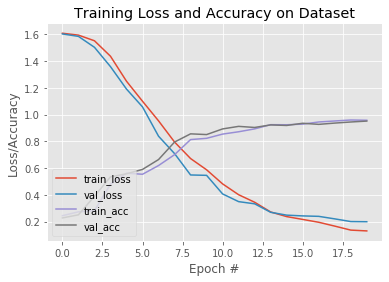

In [85]:
import matplotlib.pyplot as plt
# plot the training loss and accuracy
N = NUM_EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")